In [1]:
%matplotlib widget
import matplotlib.pyplot as plt 
from matplotlib import colors
import numpy as np 
from numpy.typing import NDArray
from typing import List, Tuple, AnyStr
from scipy.sparse.linalg import spsolve

from utils.beams import * 
from utils.solver import * 
from utils.volumes import * 

import solidspy.assemutil as ass 
import solidspy.postprocesor as pos 
import solidspy.uelutil as uel 
np.seterr(divide='ignore', invalid='ignore')

# %% ESO stress based

def ESO_stress(
    nodes: NDArray[np.float64], 
    els: NDArray[np.int_], 
    mats: NDArray[np.float64], 
    loads: NDArray[np.float64], 
    idx_BC: NDArray[np.float64], 
    niter: int, 
    RR: float, 
    ER: float, 
    volfrac: float, 
    plot: bool = False,
    dim_problem: int = 2,
    nnodes: int = 4
) -> None:
    """
    Performs Evolutionary Structural Optimization (ESO) based on stress for a 3D structure.

    Parameters
    ----------
    nodes : ndarray
        Array of node coordinates and boundary conditions with the format 
        [node number, x, y, z, BC], where BC indicates boundary conditions.
    els : ndarray
        Array of elements with the format [element number, material, node 1, node 2, ...].
    mats : ndarray
        Array of material properties with the format [E, nu, rho], where:
        - E is the Young's modulus,
        - nu is the Poisson's ratio,
        - rho is the density.
    loads : ndarray
        Array of elements with the format [element number, X load magnitud, Y load magnitud, Z load magnitud].
    idx_BC : ndarray
        Array of node indices with boundary conditions applied.
    niter : int
        Number of iterations for the ESO process.
    RR : float
        Initial relative stress threshold for removing elements.
    ER : float
        Increment of the relative stress threshold (RR) for each iteration.
    volfrac : float
        Target volume fraction for the optimized structure, expressed as a fraction of the initial volume.
    plot : bool, optional
        If True, plot the initial and optimized meshes. Defaults to False.
    dim_problem : int, optional
        Dimension of the problem (2 for 2D, 3 for 3D). Default is 2.
    nnodes : int, optional
        Number of nodes per element. For 2D problems it can be 3 or 4 and for 3D problems 4 or 8. Default is 4.

    Returns
    -------
    ELS : ndarray
        Array of the optimized elements after the ESO process.
    nodes : ndarray
        Array of the optimized nodes after the ESO process.
    UC : ndarray
      Array with the displacements.
    E_nodes : ndarray
        Strains evaluated at the nodes.
    S_nodes : ndarray
        Stresses evaluated at the nodes.

    Notes
    -----
    - This function performs structural optimization by iteratively removing elements with low relative stress.
    - The relative stress threshold (RR) increases in each iteration to progressively refine the structure.
    - The optimization stops either after reaching the specified number of iterations or if the target volume fraction is achieved.

    Process
    -------
    1. Assemble the global stiffness matrix and load vector.
    2. Solve the linear system to compute nodal displacements.
    3. Calculate element stresses and strains.
    4. Compute the von Mises stress for each element and identify elements to remove.
    5. Update the structure by removing selected elements and their associated nodes.
    6. Repeat until the specified number of iterations or target volume fraction is reached.

    Visualization
    -------------
    If `plot` is True, the function will generate:
    - A plot of the initial and optimized structures showing displacements, strains, and stresses.
    - A filled contour plot of the final optimized mesh.

    Example
    -------
    >>> optimized_els, optimized_nodes = ESO_stress(
    ...     nodes, els, mats, idx_BC, niter=10, RR=0.8, ER=0.05, volfrac=0.5, plot=True
    ... )
    """
    assert dim_problem in [2, 3], "dim_problem must be either 2 (for 2D) or 3 (for 3D)"
    assert nnodes in [3, 4, 8], "nnodes must be either 3, 4 (for 2D) or 4, 8 (for 3D)"

    uel_func = None
    if dim_problem == 2:
        if nnodes == 3:
            uel_func = uel.elast_tri3
        else:
            uel_func = uel.elast_quad4
    elif dim_problem == 3:
        if nnodes == 4:
            uel_func = uel.elast_tet4
        else:
            uel_func = uel.elast_hex8

    elsI = np.copy(els)

    # System assembly
    assem_op, IBC, neq = ass.DME(nodes[:, -dim_problem:], els, ndof_el_max=nnodes*dim_problem)
    stiff_mat, _ = ass.assembler(els, mats, nodes[:, :-dim_problem], neq, assem_op, uel=uel_func)
    rhs_vec = ass.loadasem(loads, IBC, neq)

    # System solution
    disp = spsolve(stiff_mat, rhs_vec)
    UCI = pos.complete_disp(IBC, nodes, disp, ndof_node=dim_problem)
    E_nodesI, S_nodesI = pos.strain_nodes_3d(nodes, els, mats[:,:2], UCI) if dim_problem==3 else pos.strain_nodes(nodes, els, mats[:,:2], UCI)

    Vi = calculate_mesh_volume(nodes, els) if dim_problem==3 else calculate_mesh_area(nodes, els)
    V_opt = Vi * volfrac

    ELS = None
    for _ in range(niter):
        print("Number of elements: {}".format(els.shape[0]))

        # Check equilibrium
        Vi = calculate_mesh_volume(nodes, els) if dim_problem==3 else calculate_mesh_area(nodes, els)
        if not np.allclose(stiff_mat.dot(disp)/stiff_mat.max(), rhs_vec/stiff_mat.max()) or Vi < V_opt: 
            break

        ELS = els
        
        # System assembly
        assem_op, IBC, neq = ass.DME(nodes[:, -dim_problem:], els, ndof_el_max=nnodes*dim_problem)
        stiff_mat, _ = ass.assembler(els, mats, nodes[:, :-dim_problem], neq, assem_op, uel=uel_func)
        rhs_vec = ass.loadasem(loads, IBC, neq)

        # System solution
        disp = spsolve(stiff_mat, rhs_vec)
        UC = pos.complete_disp(IBC, nodes, disp, ndof_node=dim_problem)
        E_nodes, S_nodes = pos.strain_nodes_3d(nodes, els, mats[:,:2], UC) if dim_problem==3 else pos.strain_nodes(nodes, els, mats[:,:2], UC)
        E_els, S_els = strain_els(els, E_nodes, S_nodes) # Calculate strains and stresses in elements

        vons = np.sqrt(S_els[:,0]**2 - (S_els[:,0]*S_els[:,1]) + S_els[:,1]**2 + 3*S_els[:,2]**2)

        # Remove/add elements
        RR_el = vons/vons.max() # Relative stress
        mask_del = RR_el < RR # Mask for elements to be deleted
        mask_els = protect_elsESO(els, loads, idx_BC) # Mask of elements to do not remove
        mask_del *= mask_els  
        els = np.delete(els, mask_del, 0) # Delete elements
        del_nodeESO(nodes, els, nnodes, dim_problem) # Remove nodes

        RR += ER

    if plot:
        pos.fields_plot(elsI, nodes, UCI, E_nodes=E_nodesI, S_nodes=S_nodesI) # Plot initial mesh
        pos.fields_plot(ELS, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes) # Plot optimized mesh

        fill_plot = np.ones(E_nodes.shape[0])
        plt.figure()
        tri = pos.mesh2tri(nodes, ELS)
        plt.tricontourf(tri, fill_plot, cmap='binary')
        plt.axis("image");

    return ELS, nodes, UC, E_nodes, S_nodes


In [2]:
load_directions = np.array([[0, 1e8, 0], [1e8, 0, 0], [0, 0, -1e8]])
load_positions = np.array([[5, 5, 9], [1, 1, 9], [8, 8, 9]])

# Call the function
nodes, mats, els, loads, idx_BC = beam_3d(
    L=10, 
    H=10, 
    W=10, 
    E=206.8e9, 
    v=0.28, 
    nx=10, 
    ny=10, 
    nz=10, 
    dirs=load_directions, 
    positions=load_positions
)

els, nodes, UC, E_nodes, S_nodes = ESO_stress(
    nodes=nodes, 
    els=els, 
    mats=mats, 
    loads=loads, 
    idx_BC=idx_BC, 
    niter=200, 
    RR=0.005, 
    ER=0.05, 
    volfrac=0.5, 
    plot=False,
    dim_problem=3, 
    nnodes=8)

Number of elements: 1000
Number of elements: 735
Number of elements: 354


/home/kssgarcia/anaconda3/envs/solids-test2/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


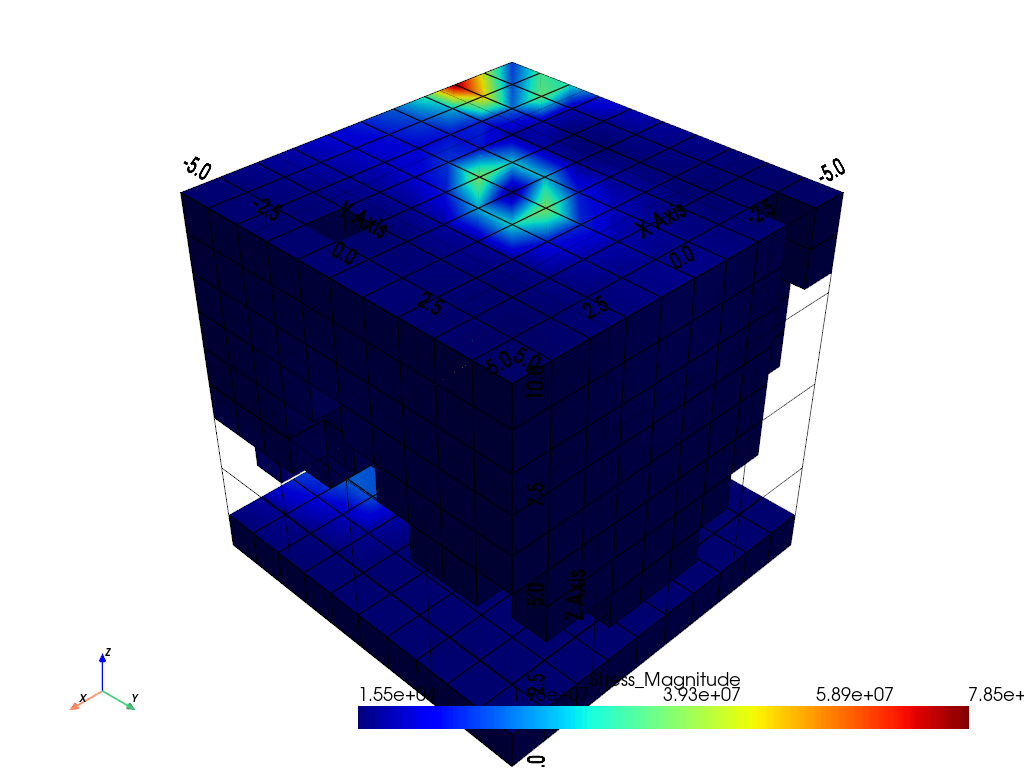

In [3]:
import numpy as np
import pyvista as pv

# Example inputs (replace with your actual data)
# nodes: [node_num, x, y, z, BCx, BCy, BCz]
# els: [element_num, material, node1, node2, ..., node8]
# E_nodes: strain at each node, shape: (Nnodes, n_components)
# S_nodes: stress at each node, shape: (Nnodes, n_components)

# 1. Extract nodal coordinates
# Assuming nodes is of shape (Nnodes, 7) and columns are [id, x, y, z, BCx, BCy, BCz]
node_ids = nodes[:, 0].astype(int)
points = nodes[:, 1:4]  # x, y, z coordinates

# 2. Construct the connectivity array for UnstructuredGrid
# PyVista expects a cell array where each cell is represented as:
# [number_of_points_in_cell, pt0, pt1, ..., pt_(n-1), number_of_points_in_next_cell, ...]
# For a hexahedral element (8-nodes), it would look like:
# [8, node_id0, node_id1, node_id2, node_id3, node_id4, node_id5, node_id6, node_id7, 8, ...]

# Extract element connectivity (assuming els: [element_num, material, node1, ..., node8])
element_connectivity = els[:, 3:].astype(int)  # node indices for each element
num_elems = element_connectivity.shape[0]

# Build the cell array
# Each cell: [8, n0, n1, n2, n3, n4, n5, n6, n7]
cells = np.hstack([np.array([8]), element_connectivity[0]])
for i in range(1, num_elems):
    cells = np.hstack([cells, np.array([8]), element_connectivity[i]])

# 3. Define the cell types
# For VTK, a hexahedral cell type = VTK_HEXAHEDRON = 12
cell_types = np.full(num_elems, 12, dtype=np.uint8)

# 4. Create the UnstructuredGrid
grid = pv.UnstructuredGrid(cells, cell_types, points)

# 5. Attach strain or stress data as point data
# Here we choose stress (S_nodes). Suppose S_nodes is shape (Nnodes, 6) for a stress tensor.
# You can choose a single component or compute an equivalent stress (like von Mises) if needed.
# For simplicity, let's take the first stress component, or compute a magnitude if it's a vector.

# Example: If S_nodes is a vector of shape (Nnodes, 3):
Sx = S_nodes[:, 0]
Sy = S_nodes[:, 1]
Sz = S_nodes[:, 2]
S_magnitude = np.sqrt(Sx**2 + Sy**2 + Sz**2)

# Add this as point data
grid.point_data["Stress_Magnitude"] = S_magnitude

# Alternatively, if you want to plot strain:
# E_magnitude = np.linalg.norm(E_nodes, axis=1)  # if it's vector-like
# grid.point_data["Strain_Magnitude"] = E_magnitude

# 6. Plot the mesh
# Use "Stress_Magnitude" as the scalars
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars="Stress_Magnitude", cmap="jet", show_edges=True)
plotter.add_axes()
plotter.show_bounds(grid="front")
plotter.show()


In [5]:
print(loads)

[[ 6.700e+02  0.000e+00  1.000e+08  0.000e+00]
 [ 1.420e+02  1.000e+08  0.000e+00  0.000e+00]
 [ 1.066e+03  0.000e+00  0.000e+00 -1.000e+08]]


/home/kssgarcia/anaconda3/envs/solids-test2/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


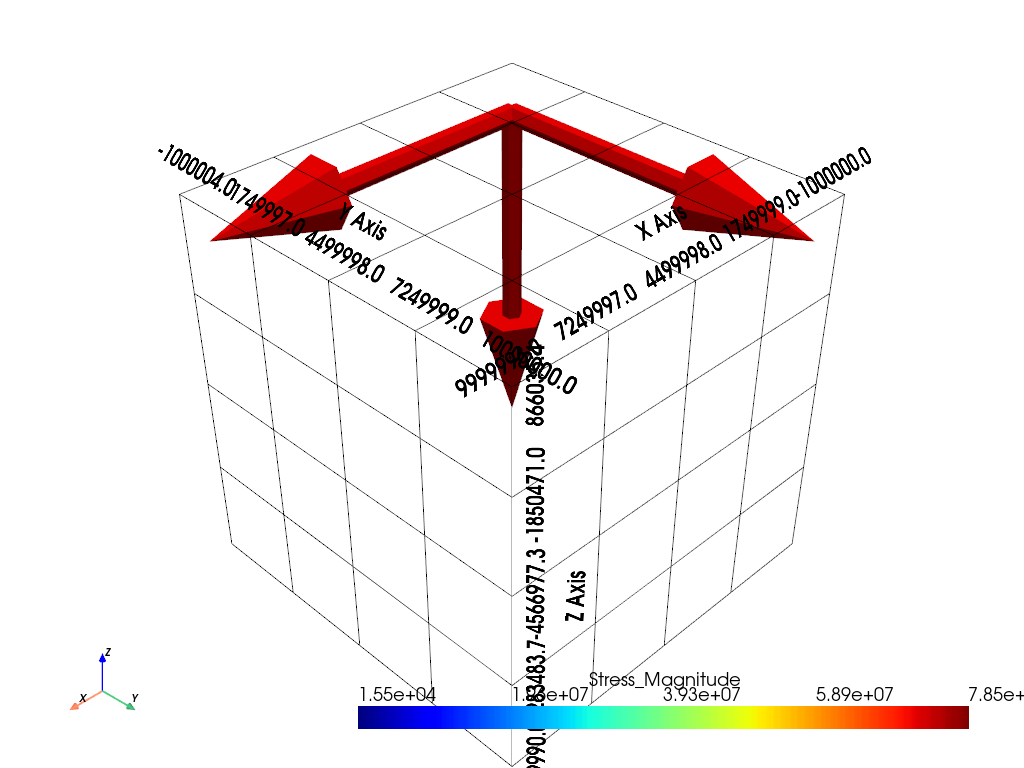

In [8]:
# Assuming:
# loads: ndarray of shape (Nloads, 4): [node_num, Fx, Fy, Fz]
# nodes: ndarray with node coords as described previously

# Extract the node coordinates and IDs
node_ids = nodes[:, 0].astype(int)
points = nodes[:, 1:4]  # (x, y, z)

force_points = points[loads[:, 0].astype(int)]

# Force vectors
force_vectors = loads[:, 1:4]  # (Fx, Fy, Fz)

# Create a PolyData object for these force application points
force_poly = pv.PolyData(force_points)

# Add the force vectors as point data
force_poly["force_vectors"] = force_vectors

# Create arrow glyphs representing forces
# The factor controls the length scale of the arrows
arrow_glyphs = force_poly.glyph(orient="force_vectors", scale="force_vectors", factor=0.1)

# Now we have:
# `grid` - your FEM mesh as UnstructuredGrid
# `arrow_glyphs` - the arrows representing forces

plotter = pv.Plotter()

# Add your original mesh
plotter.add_mesh(grid, scalars="Stress_Magnitude", cmap="jet", show_edges=True)

# Add the force arrows
plotter.add_mesh(arrow_glyphs, color="red")

plotter.add_axes()
plotter.show_bounds(grid="front")
plotter.show()
